# Convert FITS files to a format for Bruce

In [27]:
# imports
import numpy as np

from astropy.io import fits
from astropy import units

from linetools.spectra import xspectrum1d

# Load

In [2]:
cpd = fits.open('CPD-56_F.fits')

In [3]:
cpd.info()

Filename: CPD-56_F.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      84   (15558,)   float32   


## Header

In [6]:
cpd[0].header

SIMPLE  =                    T /                                                
BITPIX  =                  -32 /                                                
NAXIS   =                    1 /                                                
EXTEND  =                    T /Extensions may be present                       
BSCALE  =           1.00000000         / real=bzero+bscale*value                
BUNIT   = 'DU/PIXEL'                                                            
ORIGIN  = 'LCO/OCIW'                                                            
OBSERVER= 'P. Massey'                  / observer name                          
TELESCOP= 'Baade_Mag_1'                / telescope                              
SITENAME= 'LCO'                                                                 
SITEALT =                 2405         / meters                                 
SITELAT =            -29.01423         / latitude                               
SITELONG=            -70.692

### Log-linear

In [9]:
cdelt1 = cpd[0].header['CDELT1']
crpix1 = cpd[0].header['CRPIX1']
crval1 = cpd[0].header['CRVAL1']
naxis1 = cpd[0].header['NAXIS1']

In [12]:
wave = 10.**(crval1 + cdelt1*np.arange(naxis1))
wave

array([  3283.62540017,   3283.86637491,   3284.10736733, ...,
        10282.442274  ,  10283.19686946,  10283.95152031])

In [13]:
dwv = np.abs(wave-np.roll(wave,1))
np.median(dwv)

0.4264564889367648

In [15]:
dwv[0] = dwv[1]
dwv

array([ 0.24097474,  0.24097474,  0.24099242, ...,  0.7545401 ,
        0.75459547,  0.75465085])

### Linear

In [16]:
cdelt = 0.25

## Xspec

In [18]:
xspec = xspectrum1d.XSpectrum1D.from_file('CPD-56_F.fits')

/home/xavier/local/Python/linetools/linetools/spectra/xspectrum1d.py:108: UserWarning: Assuming wavelength unit is Angstroms
  warnings.warn("Assuming wavelength unit is Angstroms")


In [22]:
npix = 28000
new_wave = 10.**(crval1) + np.arange(npix)*cdelt
new_wave[-1]

10283.375400167715

## Rebin

In [25]:
xspec.sig

<Quantity [ 88.03932953, 86.71235657, 86.65074158,...,  17.23428345,
            17.11695099, 17.12973213]>

In [23]:
new_spec = xspec.rebin?

In [28]:
new_spec = xspec.rebin(new_wave*units.AA, grow_bad_sig=True)

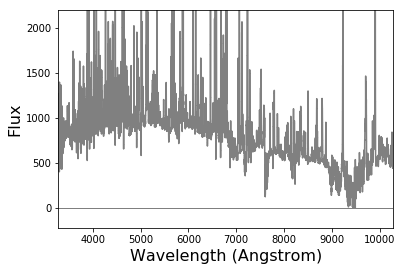

In [29]:
new_spec.plot()

## Header

In [30]:
new_head = cpd[0].header.copy()

In [60]:
new_head['CDELT1'] = cdelt
new_head['CRVAL1'] = new_wave[0]
new_head['DC-FLAG'] = 0

In [61]:
new_head

SIMPLE  =                    T /                                                
BITPIX  =                  -32 /                                                
NAXIS   =                    1 /                                                
BSCALE  =           1.00000000         / real=bzero+bscale*value                
BUNIT   = 'DU/PIXEL'                                                            
ORIGIN  = 'LCO/OCIW'                                                            
OBSERVER= 'P. Massey'                  / observer name                          
TELESCOP= 'Baade_Mag_1'                / telescope                              
SITENAME= 'LCO'                                                                 
SITEALT =                 2405         / meters                                 
SITELAT =            -29.01423         / latitude                               
SITELONG=            -70.69242         / longitude                              
TIMEZONE=                   

## Write

In [62]:
len(new_spec.flux)

28000

In [63]:
prihdu = fits.PrimaryHDU(new_spec.flux.value)

In [64]:
for key in new_head.keys():
    if key in ['NAXIS1', 'COMMENT']:
        continue
    prihdu.header[key] = new_head[key]

In [65]:
hdul = fits.HDUList([prihdu])

In [66]:
hdul.writeto('CPD-56_linear.fits', overwrite=True)